# Setup

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Connect drive

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read CSV file

In [87]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CVPR/Dataset_Assign2/data.csv')
print(df.shape)
df.head(df.shape[0])

(5000, 3)


,X,Y,LABEL
0,74,436,4
1,436,6,4
2,467,196,2
3,311,155,4
4,60,393,4
...,...,...,...
4995,495,78,4
4996,280,162,4
4997,441,395,0
4998,160,141,0


In [88]:
# a function for 1-hot encoding the output labels

def normalize(input):
  if input == 0:
    return [1,0,0]
  elif input == 1:
    return [0,1,0]
  elif input == 2:
    return [0,0,1]
  else:
    return [0, 0, 0]

In [89]:
X1 = df["X"].values.tolist()
X2 = df["Y"].values.tolist()
Y = df["LABEL"].values.tolist()

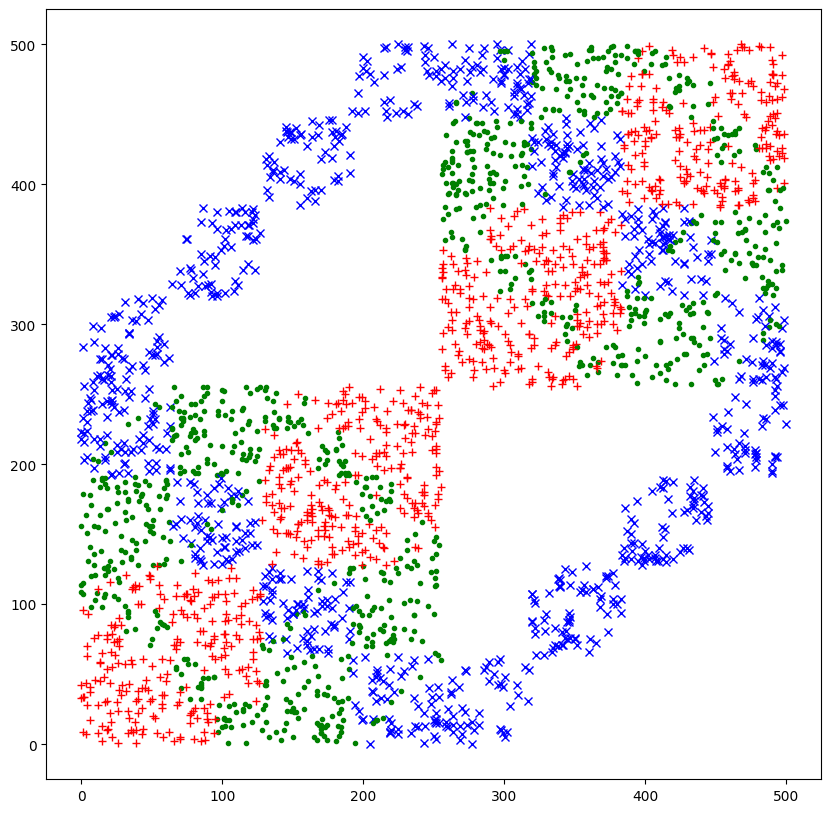

In [90]:
# plotting all points

plt.figure(figsize=(10,10))
for i in range(len(Y)):
    if Y[i] == 0:
        plt.plot(X1[i], X2[i], c="red", marker="+")
    elif Y[i] == 1:
        plt.plot(X1[i], X2[i], c="green", marker=".")
    elif Y[i] == 2:
        plt.plot(X1[i], X2[i], c="blue", marker="x")
plt.show()


In [32]:
features = list(zip(X1, X2)) #zipping the 2 input features into a list

features_np = np.array(features) #converting the list into a numpy array

In [33]:
 # normalizing the output labels to be one-hot encoded and
 # turning it into a numpy array

Y2 = np.array([normalize(i) for i in Y])

In [79]:
# dividing the total set into training (300) & testing (100) sets

features_train = features_np[:300]
Y2_train = Y2[:300]

features_test = features_np[300:]
Y2_test = Y2[300:]

# Neural Network - Training & testing

In [80]:
class NeuralNetwork(object):
    def __init__(self, inputLayerNeurons = 2, hidden1LayerNeurons = 20, hidden2LayerNeurons = 20, hidden3LayerNeurons = 20, outLayerNeurons = 3, learning_rate = 0.001, activation_type: str = 'sigmoid'):

        self.activation_type = activation_type
        self.learning_rate = learning_rate

        # random weight initialization
        self.W_H1I = np.random.randn(inputLayerNeurons, hidden1LayerNeurons)
        self.W_H2H1 = np.random.randn(hidden1LayerNeurons, hidden2LayerNeurons)
        self.W_H3H2 = np.random.randn(hidden2LayerNeurons, hidden3LayerNeurons)
        self.W_OH3 = np.random.randn(hidden3LayerNeurons, outLayerNeurons)

        # random bias initialization
        self.biases = [
            np.random.randn(hidden1LayerNeurons),
            np.random.randn(hidden2LayerNeurons),
            np.random.randn(hidden3LayerNeurons),
            np.random.randn(outLayerNeurons)
        ]

    def activation(self, x, der=False):
        if self.activation_type == 'sigmoid':
            if der == True:
                return np.exp(-x) / (1 + np.exp(-x))**2 # return x * (1-x)
            else:
                return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)

        if self.activation_type == "tanh":
            if der == True:
                return 1 - (np.tanh(x))**2 # 1 - (tanh(x))^2
            else:
                return np.tanh(x)

        if self.activation_type == "relu":
            if der == True:
                return np.where(x > 0, 1, 0)
            else:
                return np.maximum(0, x)

        if self.activation_type == "gaussian":
            if der == True:
                return -(2 * x * np.exp(-x**2)) # -2xe^(-x^2)
            else:
                return np.exp(-x**2)  # e^(-x^2)

    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_H1I) + self.biases[0]
        self.hidden1_output = self.activation(hidden1_input)

        hidden2_input = np.dot(self.hidden1_output, self.W_H2H1) + self.biases[1]
        self.hidden2_output = self.activation(hidden2_input)

        hidden3_input = np.dot(self.hidden2_output, self.W_H3H2) + self.biases[2]
        self.hidden3_output = self.activation(hidden3_input)

        output_input = np.dot(self.hidden3_output, self.W_OH3) + self.biases[3]
        pred = self.activation(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error * self.activation(pred, der=True)

        hidden3_error = output_delta.dot(self.W_OH3.T)
        hidden3_delta = self.learning_rate * hidden3_error * self.activation(self.hidden3_output, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H3H2.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.activation(self.hidden2_output, der=True)

        hidden1_error = hidden2_delta.dot(self.W_H2H1.T)
        hidden1_delta = self.learning_rate * hidden1_error * self.activation(self.hidden1_output, der=True)

        self.W_H1I += X.T.dot(hidden1_delta)
        self.W_H2H1 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_H3H2 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_OH3 += self.hidden3_output.T.dot(output_delta)

        self.biases[0] += self.learning_rate * np.sum(hidden1_delta, axis=0)
        self.biases[1] += self.learning_rate * np.sum(hidden2_delta, axis=0)
        self.biases[2] += self.learning_rate * np.sum(hidden3_delta, axis=0)
        self.biases[3] += self.learning_rate * np.sum(output_delta, axis=0)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)


<ipython-input-80-6b343e2154c6>:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)


Epoch: 0, error: 0.1814535378638769
Epoch: 10000, error: 0.13134934209975993
Epoch: 20000, error: 0.12909002328463484
Epoch: 30000, error: 0.12839414621074632
Epoch: 40000, error: 0.12806572800158036
Epoch: 50000, error: 0.12787163028269644
Epoch: 60000, error: 0.1277409156160985
Epoch: 70000, error: 0.12764511985945154
Epoch: 80000, error: 0.12757071173585804
Epoch: 90000, error: 0.12751042610033939


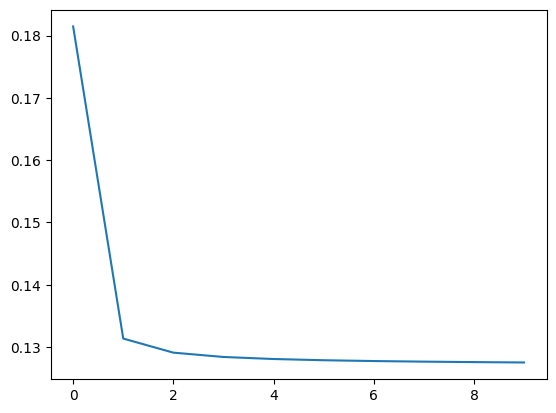

In [81]:
NN = NeuralNetwork(activation_type = 'sigmoid')
#NN = NeuralNetwork(activation_type ='tanh')
#NN = NeuralNetwork(activation_type = 'gaussian')
#NN = NeuralNetwork(activation_type = 'relu')

err_list = []

for i in range(100000):
    NN.train(features_train,Y2_train)
    err = np.mean(np.square(Y2_train - NN.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

plt.plot(err_list)
plt.show()

In [82]:
# stores a dict with the probability of each class with its class name

def getProb(pred):
    return {f'Class-{index}': p*100 for index, p in enumerate(pred)}

In [83]:
# returns the dict key with the highest probablity

def getClass(dict):
  max_key = max(dict, key=dict.get)
  return (max_key)

In [84]:
# testing a random input

pred = NN.feedForward([75,-33])
print(pred)
print(getProb(pred))
print(getClass(getProb(pred)))


[0.03663329 0.09197735 0.43234395]
{'Class-0': 3.6633285167731735, 'Class-1': 9.197734870691827, 'Class-2': 43.23439498353624}
Class-2


#Performance Metrics

In [60]:
predictions = NN.feedForward(features_test)
#print(f"Predictions: {predictions}")

# Calculate recall and F1 score
Y_true = np.argmax(Y2_test, axis=1)
Y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
print(f"Overall Accuracy: {accuracy}")

precision = precision_score(Y_true, Y_pred, average=None)
print("Precision for each class:")
for i, score in enumerate(precision):
    print(f"Class {i}: {score}")

recall = recall_score(Y_true, Y_pred, average='macro')
print(f"Recall: {recall}")

f1 = f1_score(Y_true, Y_pred, average='macro')
print(f"F1 Score overall: {f1}")

Overall Accuracy: 0.3
Precision for each class:
Class 0: 0.7022397891963109
Class 1: 0.2149886449659349
Class 2: 0.23787528868360278
Recall: 0.3864855648354843
F1 Score overall: 0.29744202969724537


<ipython-input-55-012d573cf2fb>:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)


In [61]:
# f1 score fr each class

f1_scores = f1_score(Y_true, Y_pred, average=None)

print("F1 Scores for each class:")
for i, score in enumerate(f1_scores):
    print(f"Class {i}: {score}")

F1 Scores for each class:
Class 0: 0.29197480142426735
Class 1: 0.32172189181534977
Class 2: 0.27862939585211904


#Documentation

1. `outLayerNeurons` value changed from 1 to `3` for accomodating 3 seperate classes.
2. Added a variable to hold the 2nd and 3rd hidden layer neuron counts: `hidden2LayerNeurons` & `hidden2LayerNeurons` respectively.
3. Additional 2 weight matrices were introduced to handle the weights between Hidden1-Hidden2 & Hidden2-Hidden3 connections: `W_H2H1`, `W_H3H2`.
4. For handling biases a `biases` list was constructed, which contained lists of varying sizes, where the sizes vary with the number of neurons in each layer.